# Triangle Centrality

From the paper by Paul Burkhardt:

[https://arxiv.org/pdf/2105.00110.pdf](https://arxiv.org/pdf/2105.00110.pdf)

"Triangle centrality is introduced for finding important vertices in a graph based on the concentrationof triangles surrounding each vertex.  An important vertex in triangle centrality is at the center of manytriangles, and therefore it may be in many triangles or none at all."

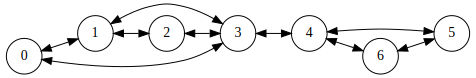

In [1]:
from pygraphblas import  *
from pygraphblas.gviz import *

# example graph from figure 2 in paper

a = 0
b = 1
c = 2
V = 3
d = 4
e = 5
f = 6
g = 7

A = Matrix.from_lists(
    [a, a, b, b, c, d, d, d, e],
    [b, V, c, V, V, V, e, f, f],
    [1.0] * 9, 8, 8
)

A = A + A.T # make symmetric
draw(A, show_weight=False)

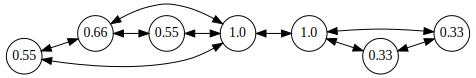

In [2]:

def triangle_centrality(A):
    I = Matrix.identity(A.type, A.nrows)
    T = A.mxm(A, mask=A)
    y = T.reduce_vector()
    k = y.reduce_float()
    T_hat = T.pattern(A.type)
    X = (3 * A) - (2 * T_hat) + I
    return (1/k) * (X @ y)

draw(A, label_vector=triangle_centrality(A), label_width=4, show_weight=False)  

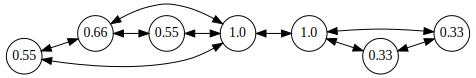

In [3]:

def triangle_centrality2(A):
    T = A.mxm(A, mask=A)
    y = T.reduce_vector()
    k = y.reduce_float()
    z = 3 * (A @ y) - 2 * (T.mxv(y, semiring=FP64.PLUS_SECOND)) + y
    return (1/k) * z

draw(A, label_vector=triangle_centrality2(A), label_width=4, show_weight=False)  

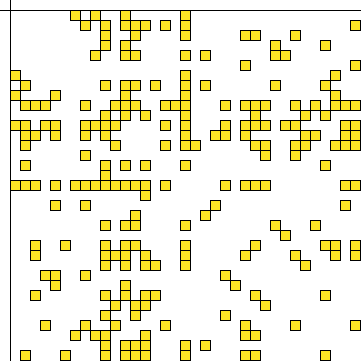

In [4]:
f = list(Matrix.ssget('Pajek/football'))
f = f[1][1]
f = f + f.T
draw_matrix(f, labels=False)

In [5]:
draw_cy(f)

Cytoscape(data={'directed': True, 'elements': {'nodes': [{'data': {'id': '0'}}, {'data': {'id': '6'}}, {'data'…

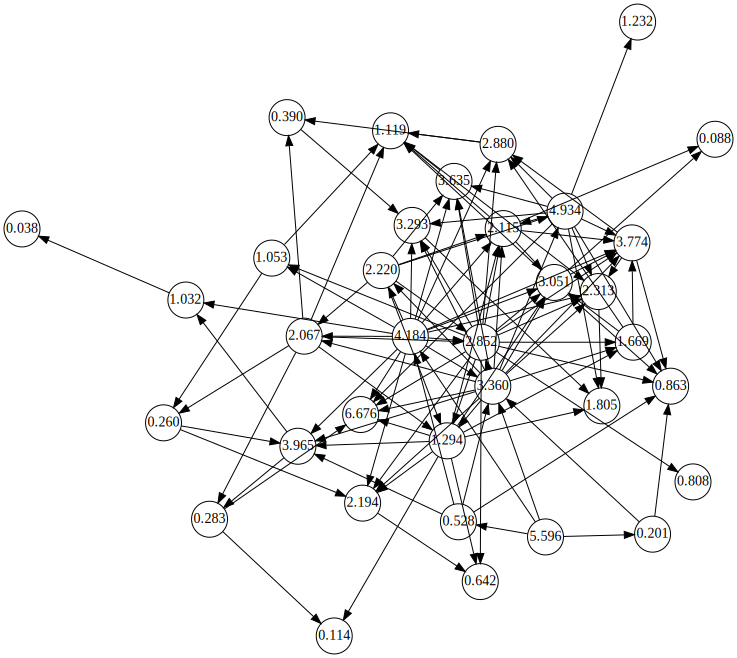

In [6]:
draw_graph(f, label_vector=triangle_centrality2(f), show_weight=False, label_width=5, graph_attr=dict(layout='neato'))

In [7]:
%timeit triangle_centrality(f)

185 µs ± 3.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
%timeit triangle_centrality2(f)

111 µs ± 669 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
